In [1]:
from brian2 import *
%matplotlib inline
prefs.codegen.target = 'numpy'
plt.style.use('seaborn-notebook')

We are going use the same neuron model as before, but now with both inhibitory and excitatory synaptic currents:

In [2]:
start_scope()
tau_m = 5*ms
V_r = -65*mV
V_th = -55*mV
tau_e = 3*ms
tau_i = 10*ms
eqs = '''dV/dt = ((V_r - V) + I_e - I_i)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt
         dI_i/dt = -I_i/tau_i : volt'''
neurons = NeuronGroup(1, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV

# synapse parameters
ne = 4000
ni = 1000
we = 1.8*mV
wi = 2.5*mV
exc_random = PoissonGroup(ne, rates=1*Hz)
inh_random = PoissonGroup(ni, rates=1*Hz)
exc_syn = Synapses(exc_random, neurons, on_pre='I_e += we')
exc_syn.connect()
inh_syn = Synapses(inh_random, neurons, on_pre='I_i += wi')
inh_syn.connect()

out_spikes = SpikeMonitor(neurons)
monitor = StateMonitor(neurons, 'V', record=True)

In [3]:
run(1*second)

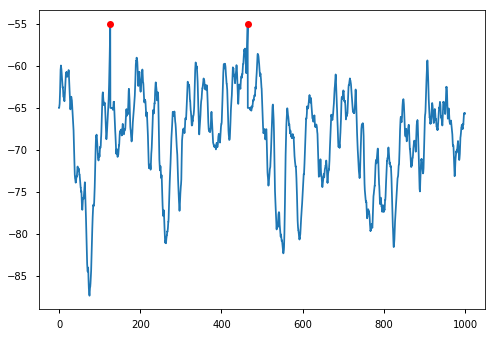

In [4]:
plt.plot(monitor.t/ms, monitor.V[0]/mV)
plt.plot(out_spikes.t/ms, np.ones(out_spikes.count[0])*V_th/mV, 'ro');

The membrane potential fluctuates strongly (balanced input), but produces few spikes.

Let's now turn 25 excitatory input neurons into "highly active" neurons, making them spike at 50Hz. We reduce the rate of the remaining excitatory neurons slightly, so to keep the total firing rate the same.

In [5]:
start_scope()
tau_m = 5*ms
V_r = -65*mV
V_th = -55*mV
tau_e = 3*ms
tau_i = 10*ms
eqs = '''dV/dt = ((V_r - V) + I_e - I_i)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt
         dI_i/dt = -I_i/tau_i : volt'''
neurons = NeuronGroup(1, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV

# synapse parameters
highly_active = 25
high_rate = 50*Hz
ne = 4000
ni = 1000
we = 1.8*mV
wi = 2.5*mV
corrected_rate = 1*Hz - (1.0*highly_active/ne)*high_rate
print(corrected_rate)
exc_random = PoissonGroup(ne-highly_active, rates=corrected_rate)
exc_high = PoissonGroup(highly_active, rates=high_rate)
inh_random = PoissonGroup(ni, rates=1*Hz)

exc_syn = Synapses(exc_random, neurons, on_pre='I_e += we')
exc_syn.connect()
exc_syn_high = Synapses(exc_high, neurons, on_pre='I_e += we')
exc_syn_high.connect()
inh_syn = Synapses(inh_random, neurons, on_pre='I_i += wi')
inh_syn.connect()

out_spikes = SpikeMonitor(neurons)
monitor = StateMonitor(neurons, 'V', record=True)

0.6875 Hz


In [6]:
run(1*second)

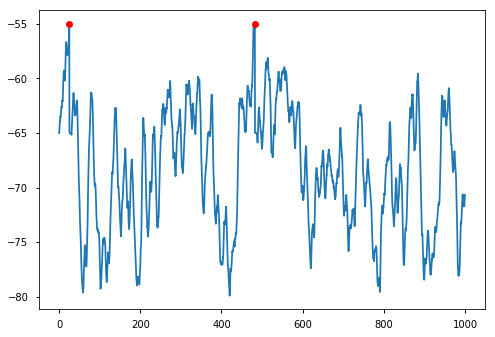

In [7]:
plt.plot(monitor.t/ms, monitor.V[0]/mV)
plt.plot(out_spikes.t/ms, np.ones(out_spikes.count[0])*V_th/mV, 'ro');

Nothing has changed. Actually, this should not be suprising, given that all neurons are spiking randomly with Poisson statistics.

Now, let's see what happens when the highly active neurons do not fire randomly, but synchronously:

In [8]:
start_scope()
tau_m = 5*ms
V_r = -65*mV
V_th = -55*mV
tau_e = 3*ms
tau_i = 10*ms
eqs = '''dV/dt = ((V_r - V) + I_e - I_i)/tau_m : volt (unless refractory)
         dI_e/dt = -I_e/tau_e : volt
         dI_i/dt = -I_i/tau_i : volt'''
neurons = NeuronGroup(1, model=eqs, threshold='V > V_th',
                      reset='V = V_r', method='exact',
                      refractory=5*ms)
neurons.V = -65*mV

# synapse parameters
highly_active = 25
high_rate = 50*Hz
ne = 4000
ni = 1000
we = 1.8*mV
wi = 2.5*mV
corrected_rate = 1*Hz - (1.0*highly_active/ne)*high_rate
print(corrected_rate)
exc_random = PoissonGroup(ne-highly_active, rates=corrected_rate)
exc_high = SpikeGeneratorGroup(highly_active,
                               np.arange(highly_active),
                               np.zeros(highly_active)*ms,
                               period=1/high_rate)
inh_random = PoissonGroup(ni, rates=1*Hz)

exc_syn = Synapses(exc_random, neurons, on_pre='I_e += we')
exc_syn.connect()
exc_syn_high = Synapses(exc_high, neurons, on_pre='I_e += we')
exc_syn_high.connect()
inh_syn = Synapses(inh_random, neurons, on_pre='I_i += wi')
inh_syn.connect()

out_spikes = SpikeMonitor(neurons)
monitor = StateMonitor(neurons, 'V', record=True)

0.6875 Hz


In [9]:
run(1*second)

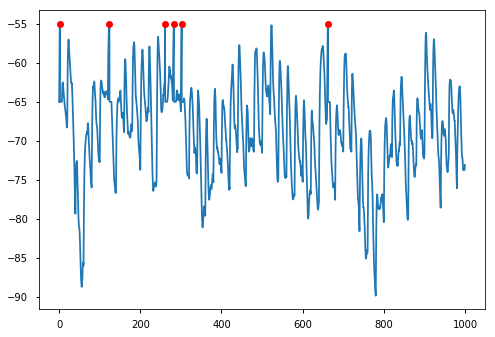

In [10]:
plt.plot(monitor.t/ms, monitor.V[0]/mV)
plt.plot(out_spikes.t/ms, np.ones(out_spikes.count[0])*V_th/mV, 'ro');

The firing rate is now significantly higher, since the synchronous activity has a high chance of pushing the neuron over its threshold.